### Importing functions

In [4]:
#the functions are imported from the folders in the same directory as the notebook
import basicFunctions.misc as misc

import basicFunctions.readIntanPorts as readIntan
import basicFunctions.LFP as LFP
import basicFunctions.spike as spike
import basicFunctions.state as state
import basicFunctions.filters as filters

import tensorflow as tf
from basicFunctions import populationDecoder
from basicFunctions import slow_clocks
# %matplotlib inline
# plt.style.use('dark_background')

%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# %matplotlib inline
# plt.style.use('dark_background')

### reloading the session

In [28]:
if reloadSession:
    import pickle
    with open(allVarsFileAdd,'rb') as f:
        data_loaded = pickle.load(f)

    globals().update(data_loaded)

# reading the data files

## spike times

In [5]:
# three columns in each loaded array: 
# col 1: channel No, channel 2000 is sync
# col 2: unit No, unit 255 is noise
# col 3: spiketime (s)

# data from three arrays were provided in this session: V1, V1b and V4

# regionsVec = np.array(['V1', 'V1b', 'V4', 'Pupil'])
# regionsDataTypeVec = np.array(['spikeTime', 'spikeTime', 'spikeTime', 'pupilSize'])

dataFileName = 'AlcaponeL_p431_nev_aligned.mat'
loadedData = sio.loadmat(defaultDataDir + dataFileName)
spikesV1 = loadedData['spikesV1']
spikesV1b = loadedData['spikesV1b']
spikesV4 = loadedData['spikesV4']

# extracting the sync times
V1syncInd = np.where(spikesV1[:,0]==2000)[0]
V1syncInd = V1syncInd[0:-1:2]
V1syncTimes = spikesV1[V1syncInd,2]

V1bsyncInd = np.where(spikesV1b[:,0]==2000)[0]
V1bsyncInd = V1bsyncInd[0:-1:2]
V1bsyncTimes = spikesV1b[V1bsyncInd,2]

V4syncInd = np.where(spikesV4[:,0]==2000)[0]
V4syncInd = V4syncInd[0:-1:2]
V4syncTimes = spikesV4[V4syncInd,2]

# extracting the spike times
V1spikeInd = np.where((spikesV1[:,0]!=2000) & (spikesV1[:,1]!=255))[0]
V1allSpikesTimes = spikesV1[V1spikeInd,2]

V1bSpikeInd = np.where((spikesV1b[:,0]!=2000) & (spikesV1b[:,1]!=255))[0]
V1bAllSpikesTimes = spikesV1b[V1bSpikeInd,2]

V4spikeInd = np.where((spikesV4[:,0]!=2000) & (spikesV4[:,1]!=255))[0]
V4allSpikesTimes = spikesV4[V4spikeInd,2]

### stimulus onset

In [53]:
dataFileName = 'AlcaponeL_p431_sync_types.mat'
loadedData = sio.loadmat(defaultDataDir + dataFileName)
syncID = loadedData['sync_types'][0][0][0][0]

stimIDs = [6,7,8,9]

stimInds = np.where(np.isin(syncID,stimIDs))[0]
firstStimInds = stimInds[np.where(syncID[stimInds-2]==2)[0]]

fristStimTimes = V1syncTimes[firstStimInds]
# looking at the stimonset time based on the sync times on different arrays there might be jitters between
# arrays that is better to be corrected to! (subtract the different sync times from the spike times between
# two consequtive syncs) -- should be done!

array([   2.87606667,    5.80456667,    7.2239    ,   12.4411    ,
         14.4001    ,   16.35906667,   18.318     ,   20.07703333,
         22.036     ,   23.99503333,   25.95406667,   27.91303333,
         29.872     ,   31.83096667,   33.78993333,   35.7889    ,
         37.7478    ,   39.70683333,   41.66576667,   43.62483333,
         45.58363333,   47.5427    ,   49.50166667,   51.46063333,
         53.46963333,   55.42863333,   57.4476    ,   59.4065    ,
         61.36546667,   64.64373333,   66.60273333,   68.56166667,
         70.56066667,   72.51963333,   74.47863333,   76.56753333,
         78.52643333,   80.48553333,   82.4445    ,   84.5333    ,
         86.4923    ,   88.45133333,   90.41033333,   92.4992    ,
         94.70803333,   96.66696667,   98.62593333,  100.6449    ,
        102.6039    ,  104.56286667,  106.52173333,  108.69073333,
        111.44933333,  113.40846667,  115.36726667,  117.56616667,
        119.52506667,  121.48403333,  123.17316667,  125.13213

In [54]:
fristStimTimes.shape

(622,)

## Pupil

In [7]:
dataFileName = 'AlcaponeL_p431_eye_aligned.mat'
loadedData = sio.loadmat(defaultDataDir + dataFileName)
pupilData = loadedData['data'][0][0]

pupilSize = pupilData[0][2,:]
pupilSize = pupilSize - np.min(pupilSize)

# set the non valid values (relating to blinks) to zero
pupilSize[pupilSize<1400] = 0

# remove the blinks
pupilSize_corrected = \
        misc.removeBlinks(pupilSize, cameraAvgFrameRate, \
        normalize = False)

framesStartTime = np.arange(0,len(pupilSize_corrected)/cameraAvgFrameRate,1/cameraAvgFrameRate)

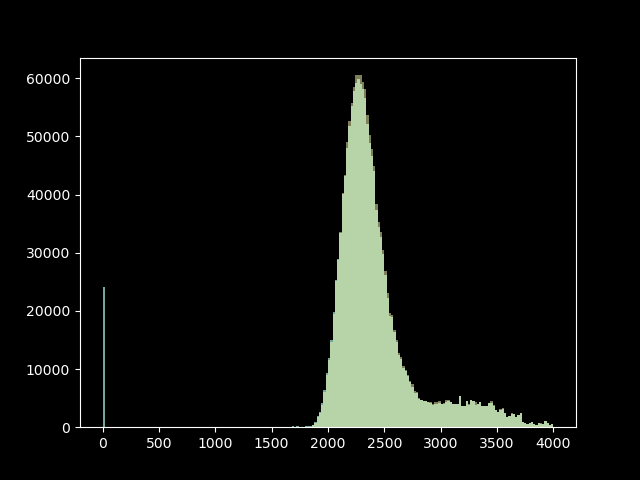

In [8]:
plt.figure()
plt.hist(pupilSize,bins=200,alpha=0.8,range=(0,4000));
plt.hist(pupilSize_corrected,bins=200,range=(0,4000),alpha=0.5);

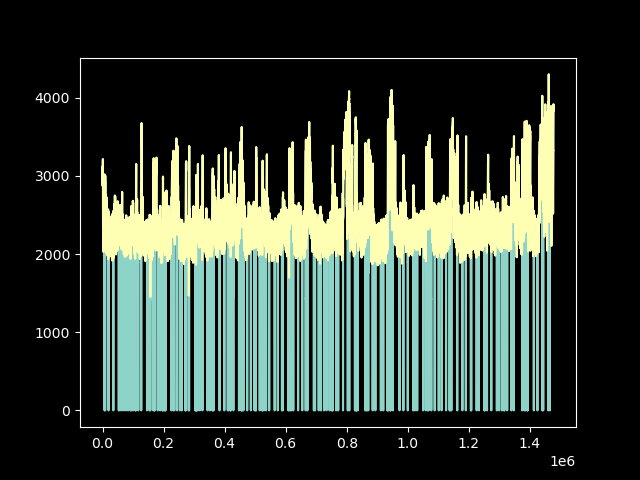

In [9]:
plt.figure()
plt.plot(pupilSize)
plt.plot(pupilSize_corrected)

### STA on the pupil - entire session - All spikes pooled

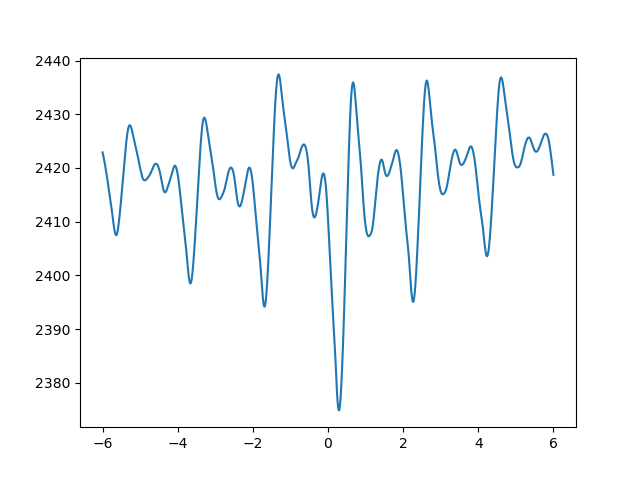

In [104]:
maxDelay = 6
maxDelayFrames = int(maxDelay*cameraAvgFrameRate)

lastFrameTime = len(pupilSize)/cameraAvgFrameRate

meanPupilSize = np.zeros(2*maxDelayFrames)

clusterSpikeTime = V1allSpikesTimes#[:1000000]

clusterSpikeTimeValid = clusterSpikeTime[(clusterSpikeTime>maxDelay)\
                                        & (clusterSpikeTime<\
                                (lastFrameTime-maxDelay))]

for spikeTimeLoop in clusterSpikeTimeValid[:]:

    frameCorrespondingToTheSpike = int(spikeTimeLoop*cameraAvgFrameRate)

    meanPupilSize = meanPupilSize + \
        pupilSize_corrected[frameCorrespondingToTheSpike-maxDelayFrames:\
                                            frameCorrespondingToTheSpike+maxDelayFrames]

meanPupilSize = meanPupilSize/len(clusterSpikeTimeValid)

plt.figure()
plt.plot(np.arange(-maxDelay,maxDelay,1/cameraAvgFrameRate),meanPupilSize)

# Cycle Detection

## loading the decoder and setting the params

6249/6249 [==============================] - 26s 4ms/step
[[4.52331897e-01 9.92695261e-01 5.00000000e-03]
 [2.75332459e-01 9.91384154e-01 1.00000000e-02]
 [2.33564338e-01 9.88949241e-01 1.50000000e-02]
 [2.05656490e-01 9.87638134e-01 2.00000000e-02]
 [1.80745458e-01 9.85390523e-01 2.50000000e-02]
 [1.63139165e-01 9.83892115e-01 3.00000000e-02]
 [1.46282075e-01 9.80333396e-01 3.50000000e-02]
 [1.28488481e-01 9.77523881e-01 4.00000000e-02]
 [1.17812324e-01 9.74152463e-01 4.50000000e-02]
 [1.07510770e-01 9.69095336e-01 5.00000000e-02]
 [9.75838172e-02 9.63663607e-01 5.50000000e-02]
 [8.84060686e-02 9.56733471e-01 6.00000000e-02]
 [7.94156209e-02 9.50739839e-01 6.50000000e-02]
 [7.09870762e-02 9.43435100e-01 7.00000000e-02]
 [6.36823375e-02 9.35568459e-01 7.50000000e-02]
 [5.75014048e-02 9.28825623e-01 8.00000000e-02]
 [5.22569770e-02 9.19647874e-01 8.50000000e-02]
 [4.60760442e-02 9.09159019e-01 9.00000000e-02]
 [4.12062184e-02 8.98295561e-01 9.50000000e-02]
 [3.59617906e-02 8.86682899e-0

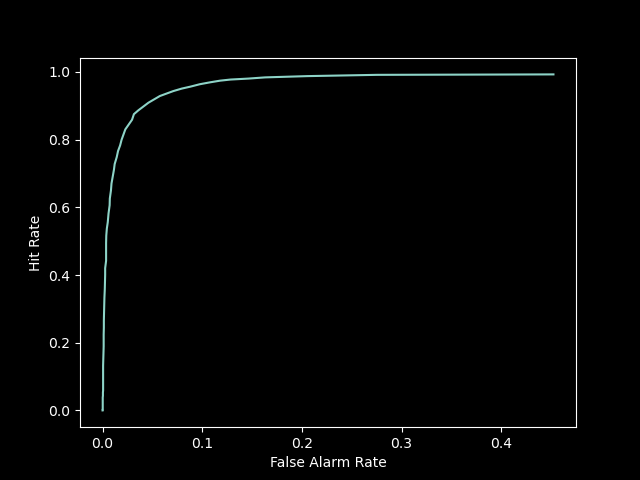

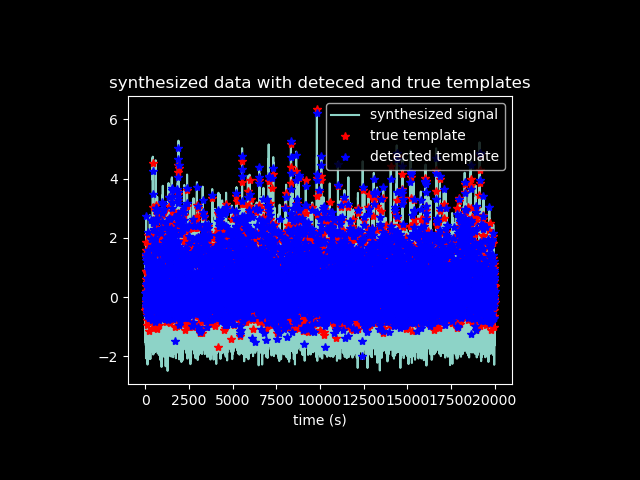

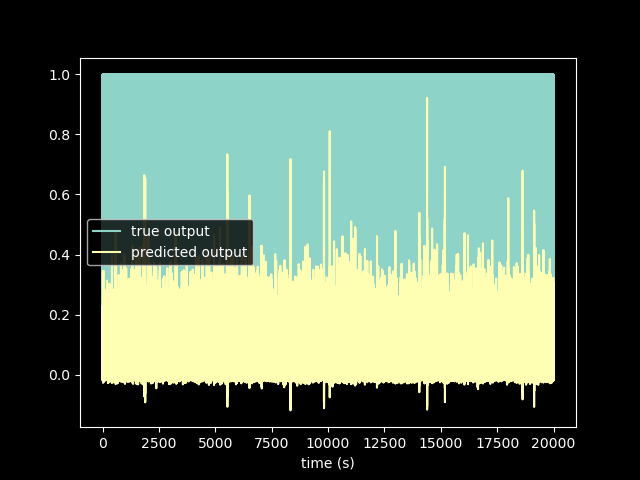

In [10]:
# loading the general model
modelAdd = \
        'Z:/Dropbox (EinsteinMed)/WorkSpaces/VIP-Inhibition/trainedDecoders/general/'\
            'lstmDigitalOutput_generalTemplate_10000s_5_percentNoise_20_WidthJitter_[200, 200]_lstmUnits_'\
            'bothsideHistory2022-06-28.pkl'

#loading the general model and its paramters trained to decode 3-s template while include [0.75, 1.5, 3, 6, 12, 24] templates
loadedModel_general_template, dt_general_3s_template,\
    binsBefore_general_template, binsAfter_general_template,\
        exitabilityTemplates_general_gaussian,\
            templateNo_general_gaussian, templatesProbVec_general_gaussian,\
                templatesHeights_general_gaussian, templatesWidths_general_gaussian,\
                    chosenDetectionThreshold = \
                        populationDecoder.loadModel(modelAdd=modelAdd)

regionsVec = np.array(['V1', 'V1b', 'V4', 'Pupil'])
regionsDataTypeVec = np.array(['spikeTime', 'spikeTime', 'spikeTime', 'pupilSize'])

# putting the data from all regions in one vectro to feed it into the functions
allRegionsData = [V1allSpikesTimes, V1bAllSpikesTimes, V4allSpikesTimes, pupilSize_corrected]

# the vector of cycles that is being detected and the data is added to the corresponding data set for the session
# this is updated as each cycle is added
allCyclesVec = []
allCycles_n = []

# the lists that are filled when each cycle is detected across regions
# V1
templateDetectedTimes_V1_allCycles = []
triggeredActivityInAllregionsByDetectedCycles_V1_allCycles = []

#V1b
templateDetectedTimes_V1b_allCycles = []
triggeredActivityInAllregionsByDetectedCycles_V1b_allCycles = []

#V4
templateDetectedTimes_V4_allCycles = []
triggeredActivityInAllregionsByDetectedCycles_V4_allCycles = []

#Pupil
templateDetectedTimes_Pupil_allCycles = []
triggeredActivityInAllregionsByDetectedCycles_Pupil_allCycles = []

## gamma Cycle

In [57]:
n = -7
cycleName = 'gamma'
defaultHistBin = 0

### V1 array

In [26]:
timePointsAllregions

[array([-7.03125000e-02, -6.93080036e-02, -6.83035072e-02, -6.72990108e-02,
        -6.62945144e-02, -6.52900180e-02, -6.42855216e-02, -6.32810252e-02,
        -6.22765288e-02, -6.12720324e-02, -6.02675360e-02, -5.92630396e-02,
        -5.82585432e-02, -5.72540468e-02, -5.62495504e-02, -5.52450540e-02,
        -5.42405576e-02, -5.32360612e-02, -5.22315647e-02, -5.12270683e-02,
        -5.02225719e-02, -4.92180755e-02, -4.82135791e-02, -4.72090827e-02,
        -4.62045863e-02, -4.52000899e-02, -4.41955935e-02, -4.31910971e-02,
        -4.21866007e-02, -4.11821043e-02, -4.01776079e-02, -3.91731115e-02,
        -3.81686151e-02, -3.71641187e-02, -3.61596223e-02, -3.51551259e-02,
        -3.41506295e-02, -3.31461331e-02, -3.21416367e-02, -3.11371403e-02,
        -3.01326439e-02, -2.91281475e-02, -2.81236511e-02, -2.71191547e-02,
        -2.61146583e-02, -2.51101619e-02, -2.41056655e-02, -2.31011691e-02,
        -2.20966727e-02, -2.10921763e-02, -2.00876799e-02, -1.90831835e-02,
        -1.8

In [111]:
from copy import deepcopy

In [112]:
templateDetectedTimes_V1_gamma15ms = deepcopy(templateDetectedTimes_V1)

59093/59093 [==============================] - 484s 8ms/step
Number of detected gamma40 cycles in V1: 44961

0.05264375000015206
0.12451875000015206
0.14561250000015208
0.18389375000015207
0.2049875000001521
0.22998750000015208
0.2479562500001521
0.2674875000001521
0.3151437500001521
0.33623750000015207
0.3628000000001521
0.38311250000015207
0.4003000000001521
0.4237375000001521
0.4440500000001521
0.4588937500001521
0.4784250000001521
0.4932687500001521
0.553425000000152
0.5737375000001521
0.6292062500001521
0.7049875000001521
0.7682687500001522
0.8292062500001521
0.8596750000001521
0.8979562500001521
0.9268625000001521
0.9518625000001522
0.9924875000001521
1.0229562500001521
1.0456125000001522
1.0768625000001522
1.097956250000152
1.125300000000152
1.1815500000001522
1.2393625000001522
1.2979562500001522
1.3448312500001522
1.3838937500001522
1.4073312500001522
1.4792062500001522
1.4987375000001522
1.547175000000152
1.570612500000152
1.6198312500001522
1.6393625000001522
1.6721750000001

1147.45655
1147.4737375000002
1147.4956125
1147.5253000000002
1147.5495187500003
1147.5674875000002
1147.5924875000003
1147.6143625000002
1147.6331125000002
1147.6518625
1147.6682687500002
1147.6846750000002
1147.7049875000002
1147.7409250000003
1147.76514375
1147.8690500000002
1147.8917062500002
1147.9112375000002
1147.9432687500002
1147.9940500000002
1148.0245187500002
1148.0534250000003
1148.0799875000002
1148.1128
1148.1846750000002
1148.20655
1148.2792062500002
1148.3307687500003
1148.3495187500002
1148.3807687500002
1148.4401437500003
1148.45655
1148.4729562500002
1148.4893625000002
1148.5096750000002
1148.53858125
1148.5573312500003
1148.5792062500002
1148.6237375000003
1148.659675
1148.6768625000002
1148.6940500000003
1148.7190500000002
1148.7385812500002
1148.76905
1148.8128000000002
1148.8323312500002
1148.8503000000003
1148.8963937500002
1148.9268625000002
1148.9503000000002
1148.9963937500002
1149.0174875000002
1149.0393625000002
1149.0588937500002
1149.0893625
1149.1104562

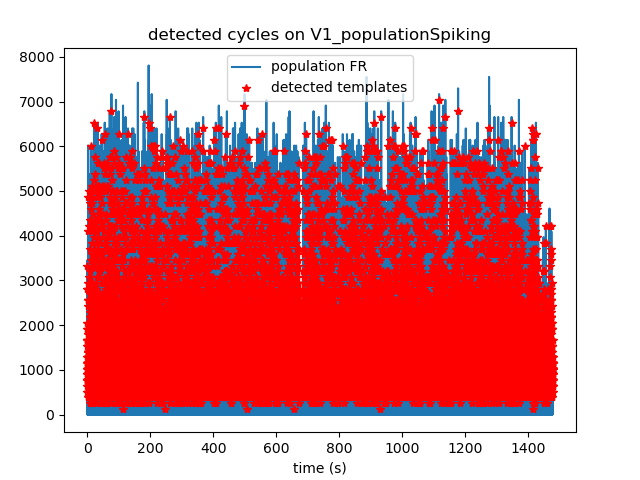

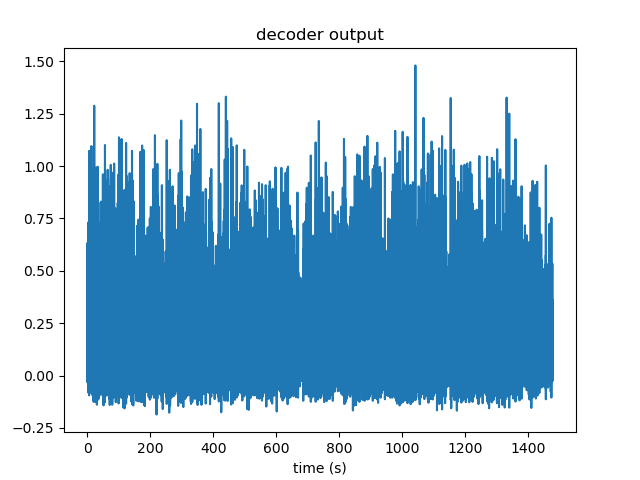

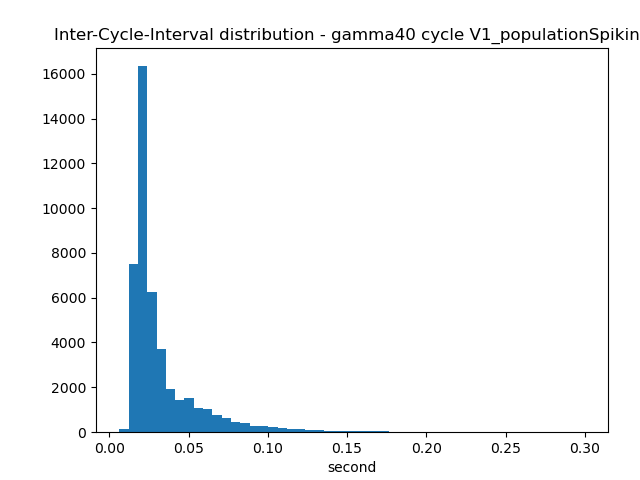

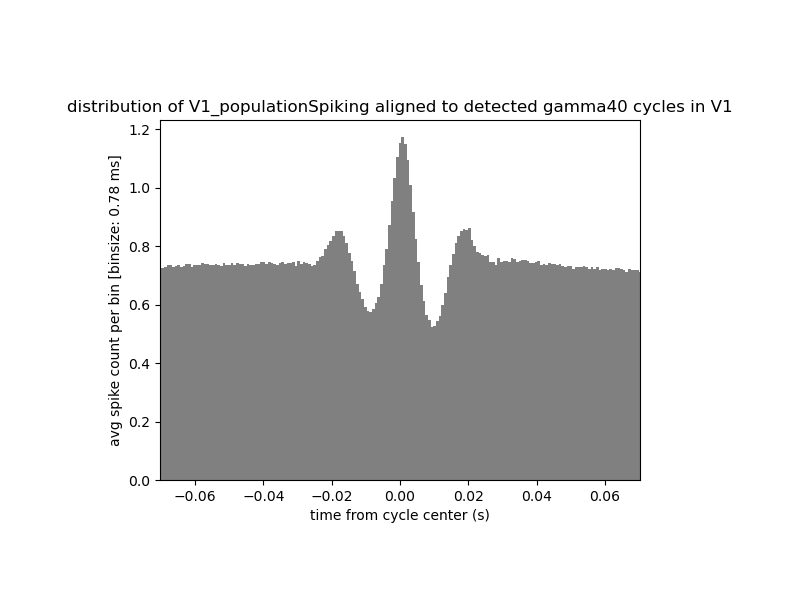

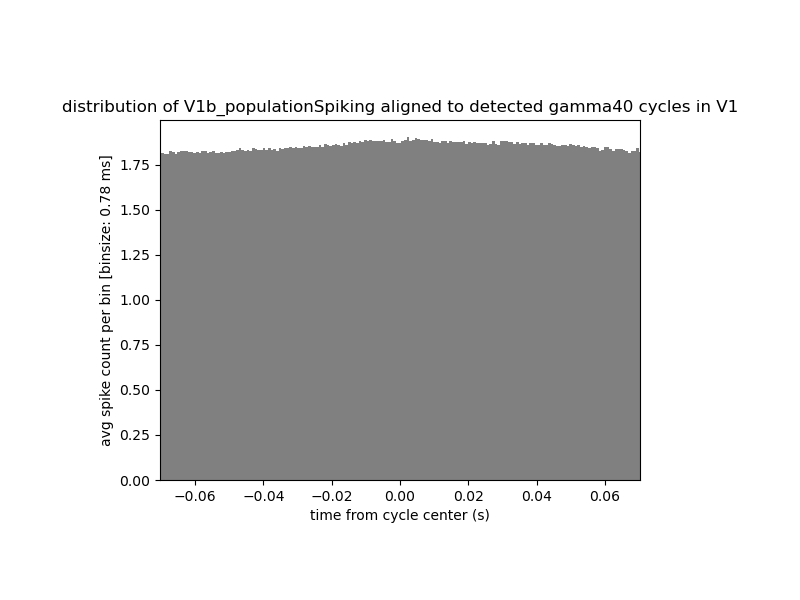

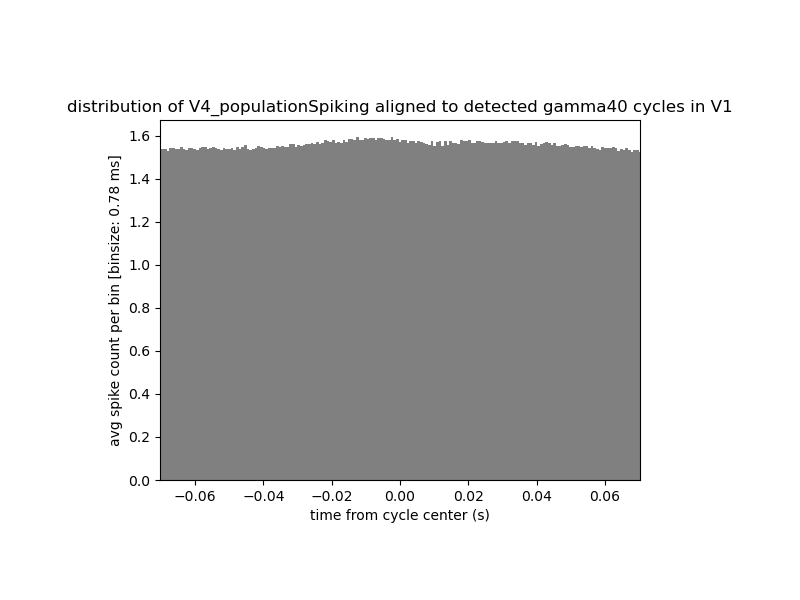

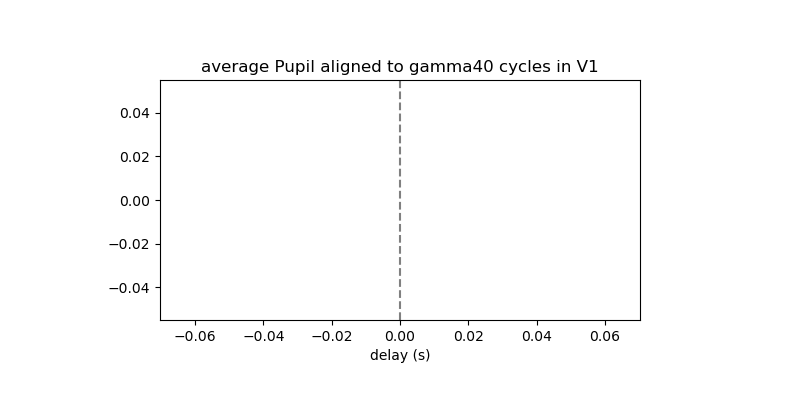

In [113]:
plt.style.use('default')
n = -7
cycleName = 'gamma40'
highGammaDur=0.025


templateDetectedTimes_V1_gamma25ms, triggeredActivityInAllregionsByDetectedCycles_V1, timePointsAllregions =\
    populationDecoder.applyGeneralDecoder(inputAllRegions=allRegionsData, regionName='V1',\
        n=n, cycleName=cycleName, regionVec=regionsVec, regionsDataTypeVec=regionsDataTypeVec,\
            loadedModel_general_template=loadedModel_general_template,\
              dt_general_3s_template=dt_general_3s_template,\
                  binsAfter_general_template=binsAfter_general_template,\
                      binsBefore_general_template=binsBefore_general_template,\
                          detectionThreshold=chosenDetectionThreshold,\
                              showFigs=True, saveFigs=True, interCycleIntervalFig=True,targetedWidth=highGammaDur,\
                                  sessionName=sessionName, continuousInputSampingRate=cameraAvgFrameRate,\
                                         histBinWidth=defaultHistBin, wholeSession=True, maxNumberForDeteced=2000)

### V1b array

2677/2677 [==============================] - 23s 8ms/step
Number of detected gamma cycles in V1b: 1999

0.03156874999995125
0.05109999999995125
0.08234999999995124
0.10109999999995126
0.12922499999995124
0.14953749999995125
0.16984999999995126
0.22141249999995127
0.24328749999995125
0.2885999999999513
0.3393812499999513
0.3635999999999513
0.3815687499999513
0.3987562499999513
0.4167249999999513
0.4362562499999513
0.4635999999999513
0.4878187499999513
0.5128187499999513
0.5331312499999513
0.5635999999999513
0.5823499999999513
0.6471937499999513
0.6675062499999513
0.6846937499999513
0.7042249999999513
0.7260999999999513
0.7557874999999513
0.7878187499999513
0.8120374999999513
0.8300062499999513
0.8581312499999513
0.8768812499999513
0.9237562499999513
0.9409437499999513
0.9596937499999513
0.9760999999999513
0.9995374999999513
1.0260999999999512
1.0479749999999513
1.0831312499999513
1.1026624999999513
1.1292249999999513
1.1800062499999513
1.1987562499999513
1.2159437499999513
1.24328749999

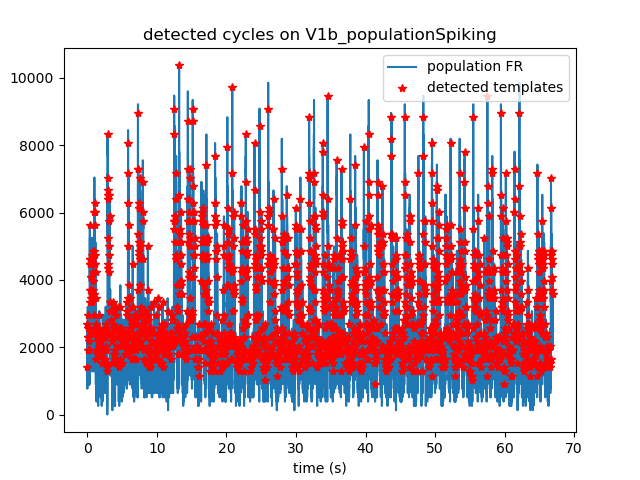

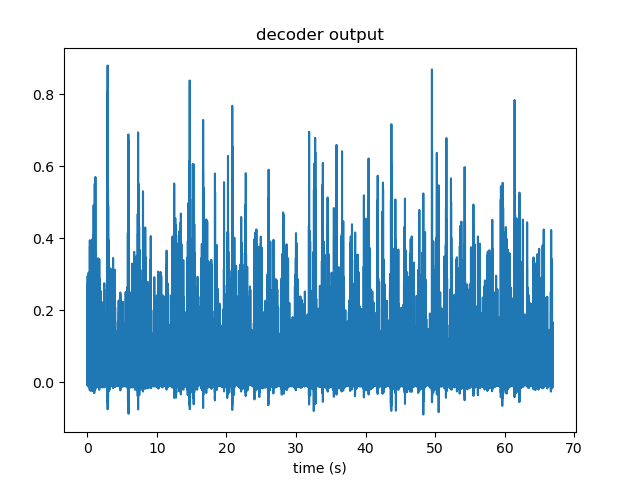

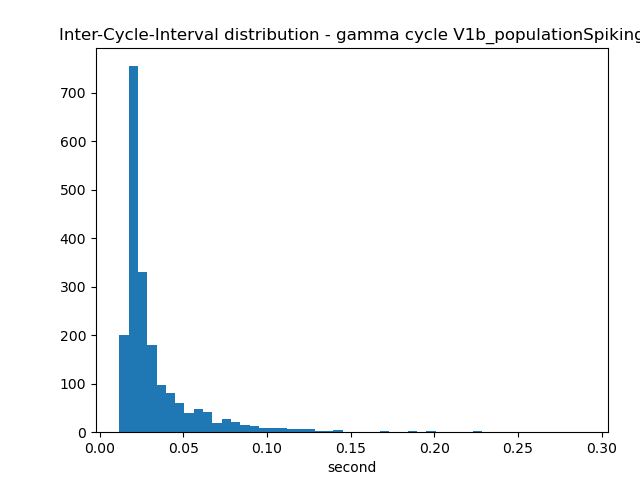

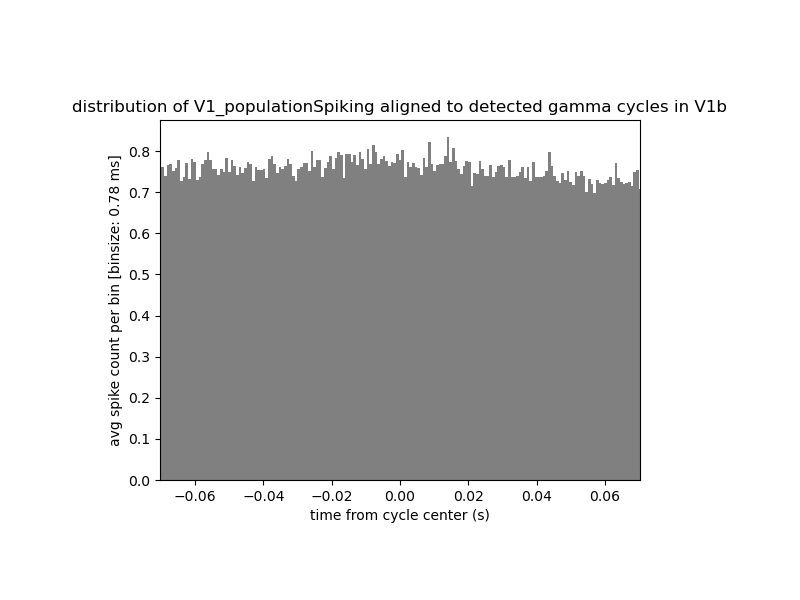

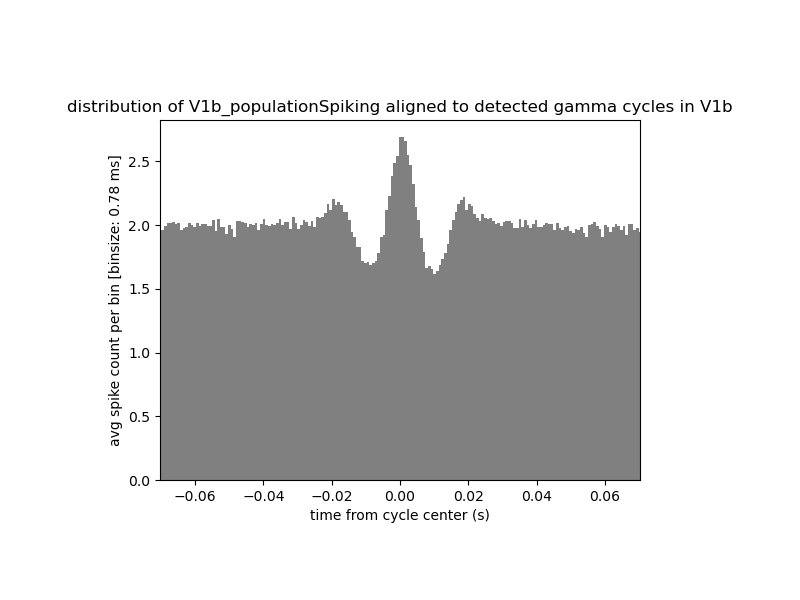

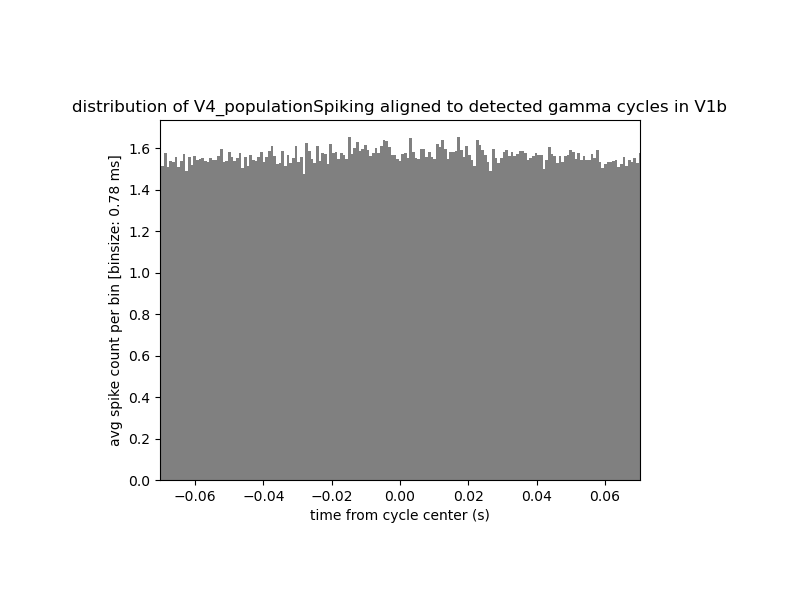

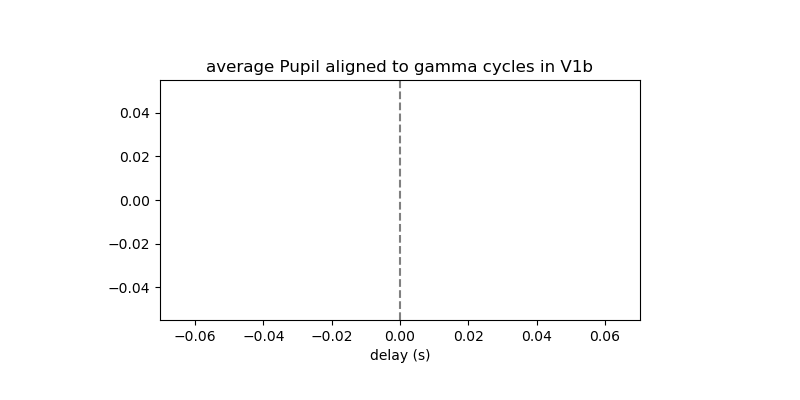

In [30]:
templateDetectedTimes_V1b, triggeredActivityInAllregionsByDetectedCycles_V1b, timePointsAllregions =\
    populationDecoder.applyGeneralDecoder(inputAllRegions=allRegionsData, regionName='V1b',\
        n=n, cycleName=cycleName, regionVec=regionsVec, regionsDataTypeVec=regionsDataTypeVec,\
            loadedModel_general_template=loadedModel_general_template,\
              dt_general_3s_template=dt_general_3s_template,\
                  binsAfter_general_template=binsAfter_general_template,\
                      binsBefore_general_template=binsBefore_general_template,\
                          detectionThreshold=chosenDetectionThreshold,\
                              showFigs=True, saveFigs=True, interCycleIntervalFig=True,\
                                  sessionName=sessionName, continuousInputSampingRate=cameraAvgFrameRate,\
                                        histBinWidth=defaultHistBin, wholeSession=False, maxNumberForDeteced=2000)

### V4 array

2677/2677 [==============================] - 23s 8ms/step
Number of detected gamma cycles in V4: 1969

0.03372708333345144
0.05247708333345144
0.06966458333345144
0.13685208333345145
0.20169583333345145
0.21732083333345145
0.23919583333345146
0.2641958333334514
0.32825833333345145
0.34935208333345147
0.39075833333345145
0.4095083333334515
0.4290395833334515
0.4524770833334515
0.4681020833334515
0.48528958333345146
0.5009145833334514
0.5196645833334514
0.5368520833334515
0.5548208333334514
0.5813833333334515
0.6063833333334515
0.6352895833334515
0.6548208333334515
0.6931020833334515
0.7095083333334515
0.7360708333334515
0.7774770833334514
0.7977895833334515
0.8149770833334515
0.8298208333334515
0.8524770833334515
0.8876333333334515
0.9571645833334514
0.9806020833334514
1.0313833333334514
1.0509145833334514
1.0759145833334516
1.1438833333334515
1.1634145833334515
1.1899770833334515
1.2095083333334515
1.2477895833334516
1.2782583333334516
1.3009145833334514
1.3266958333334515
1.3493520833

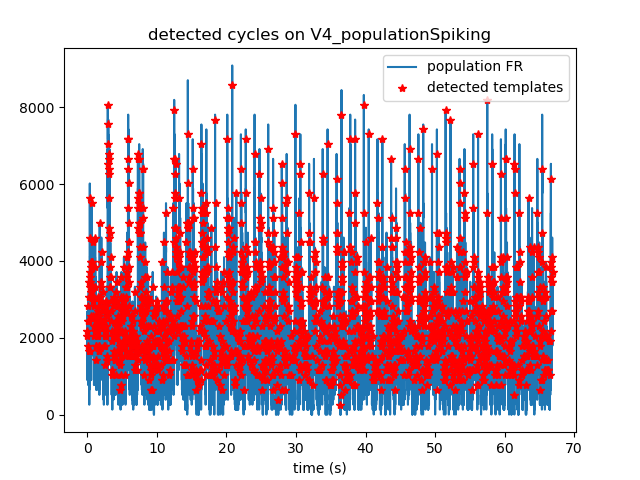

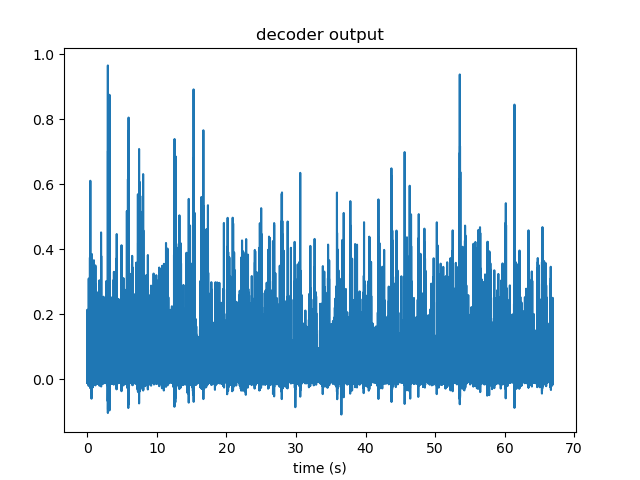

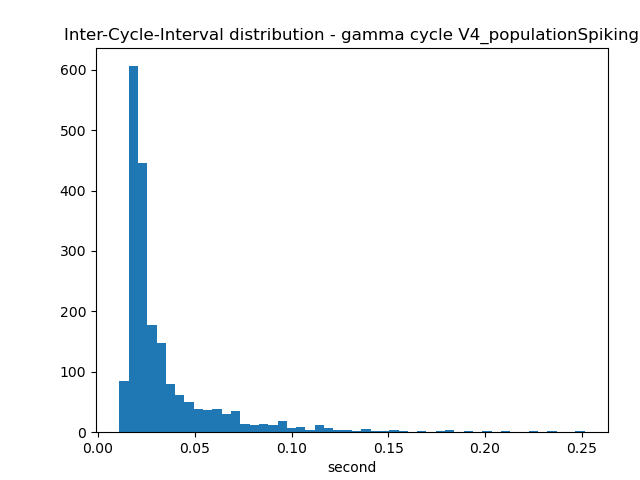

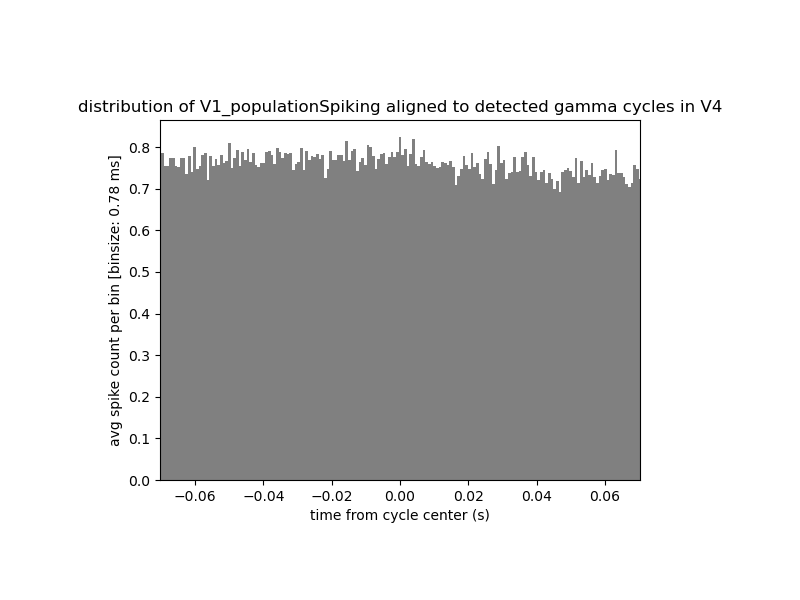

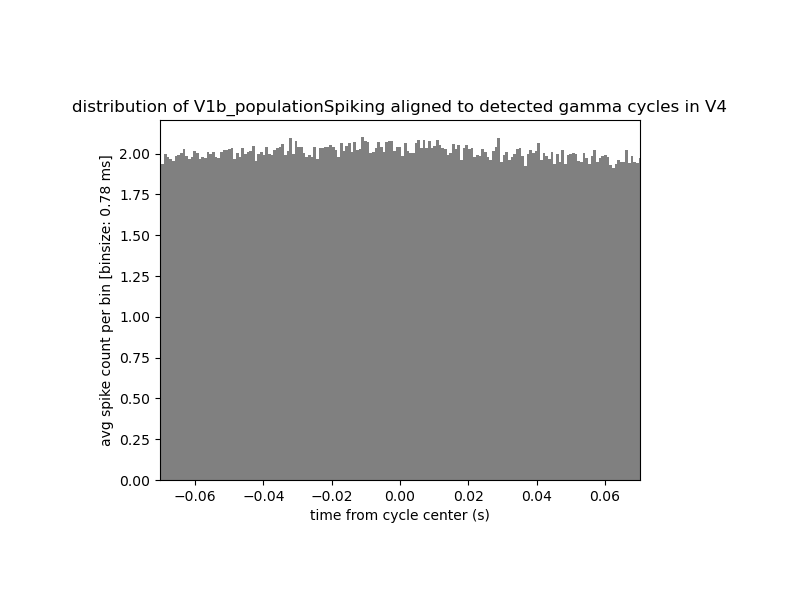

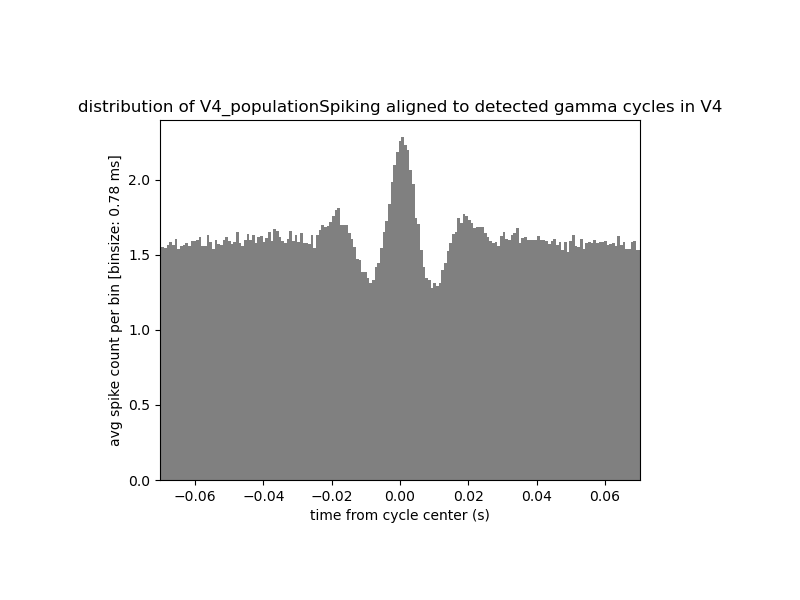

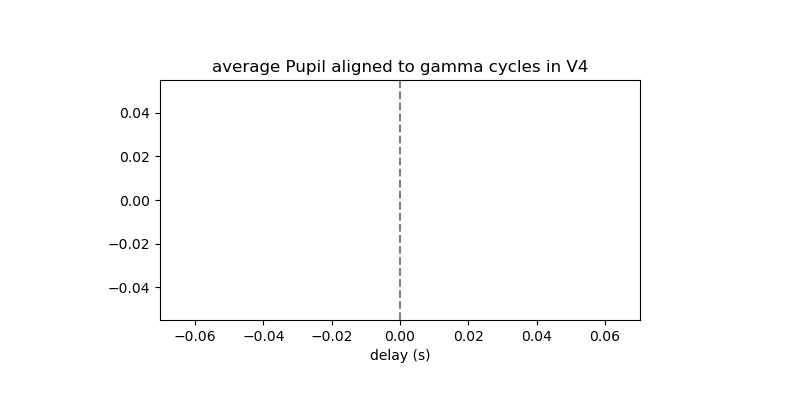

In [34]:
templateDetectedTimes_V4, triggeredActivityInAllregionsByDetectedCycles_V4, timePointsAllregions =\
    populationDecoder.applyGeneralDecoder(inputAllRegions=allRegionsData, regionName='V4',\
        n=n, cycleName=cycleName, regionVec=regionsVec, regionsDataTypeVec=regionsDataTypeVec,\
            loadedModel_general_template=loadedModel_general_template,\
              dt_general_3s_template=dt_general_3s_template,\
                  binsAfter_general_template=binsAfter_general_template,\
                      binsBefore_general_template=binsBefore_general_template,\
                          detectionThreshold=chosenDetectionThreshold,\
                              showFigs=True, saveFigs=True, interCycleIntervalFig=True,\
                                  sessionName=sessionName, continuousInputSampingRate=cameraAvgFrameRate,\
                                        histBinWidth=defaultHistBin, wholeSession=False, maxNumberForDeteced=2000)

### Pupil

131577/131577 [==============================] - 504s 4ms/step
Number of detected pupilFastDilation100 cycles in Pupil: 48749



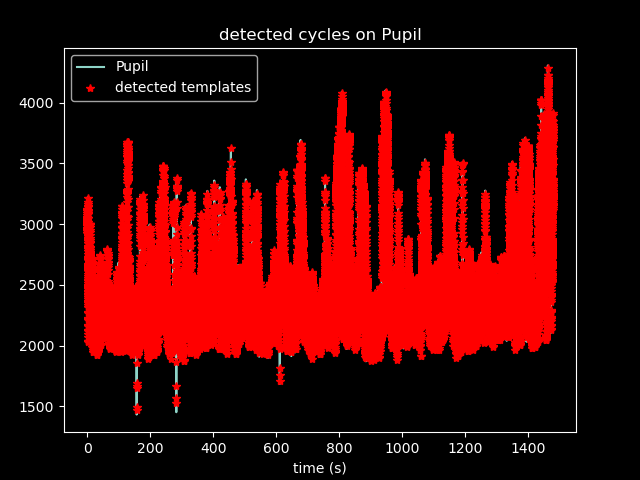

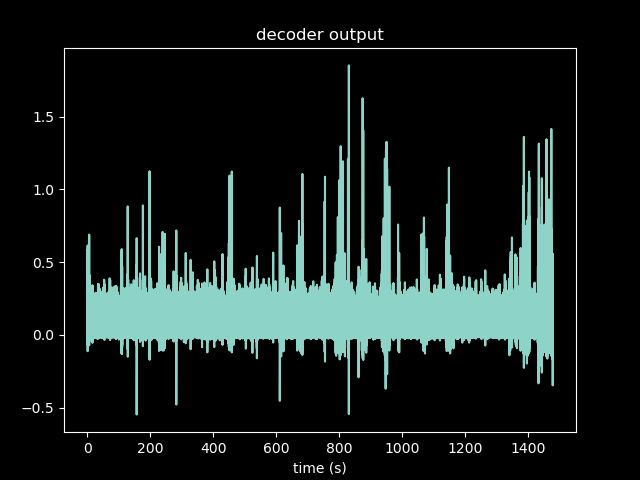

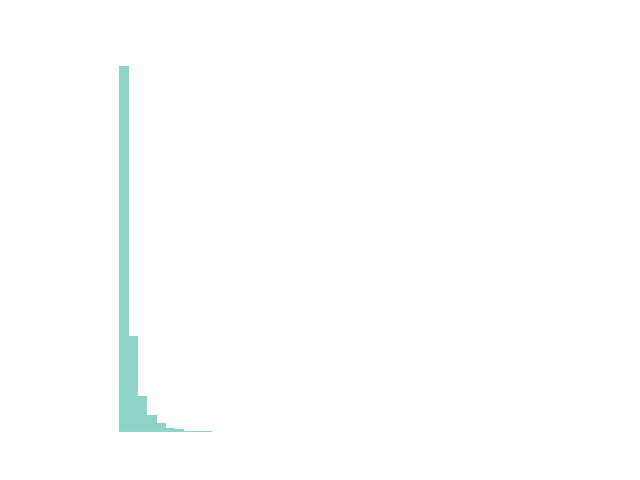

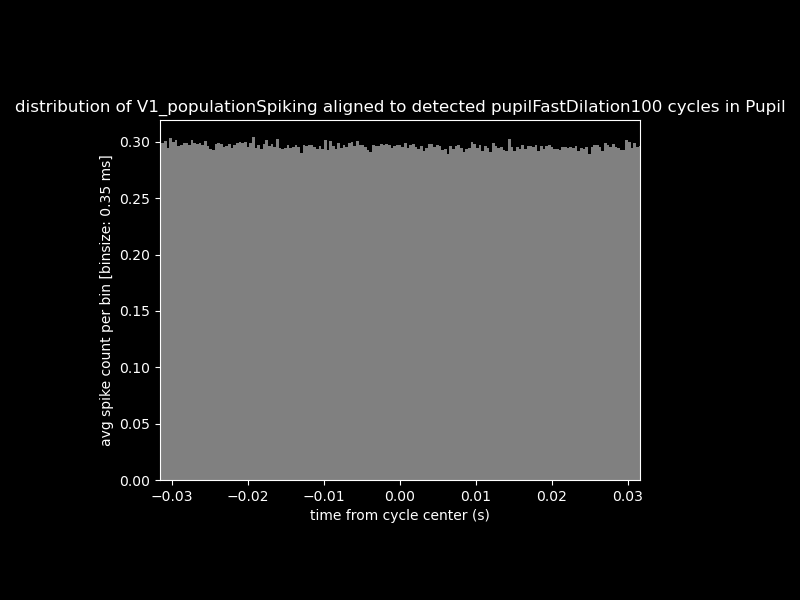

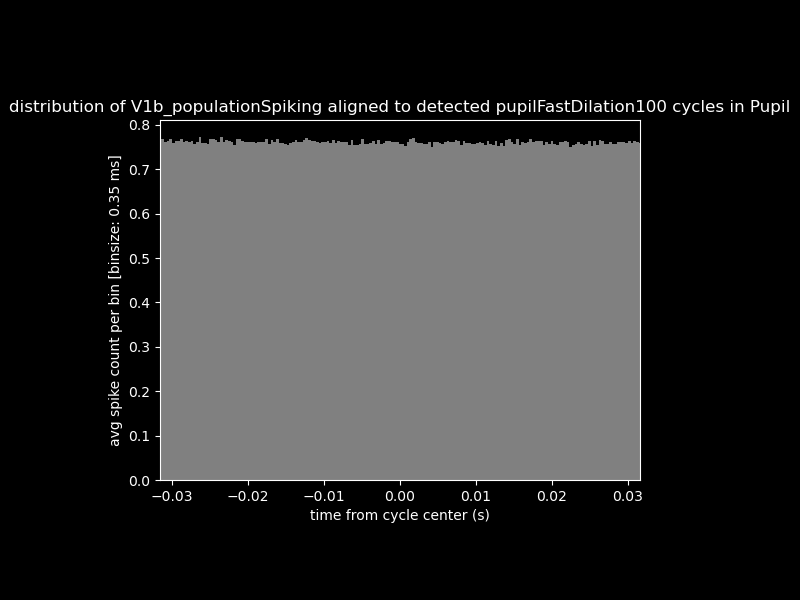

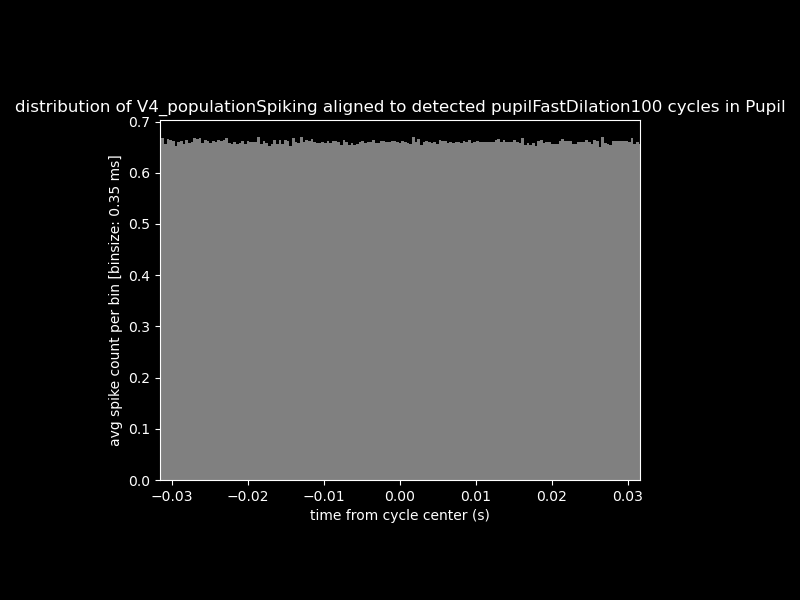

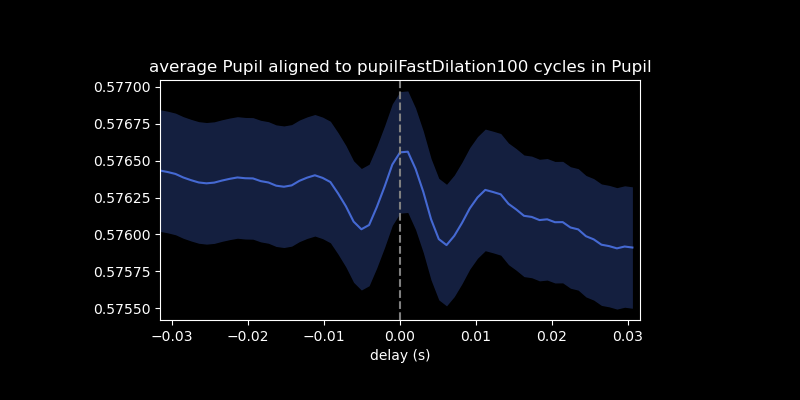

In [13]:
n = None
cycleName = 'pupilFastDilation100'
pupilFastDilationDur = 1/95
defaultHistBin=0

templateDetectedTimes_Pupil_fast100, triggeredActivityInAllregionsByDetectedCycles_Pupil_fast100, timePointsAllregions_fast100 =\
    populationDecoder.applyGeneralDecoder(inputAllRegions=allRegionsData, regionName='Pupil',\
        n=n, cycleName=cycleName, regionVec=regionsVec, regionsDataTypeVec=regionsDataTypeVec,\
            loadedModel_general_template=loadedModel_general_template,\
              dt_general_3s_template=dt_general_3s_template,\
                  binsAfter_general_template=binsAfter_general_template,\
                      binsBefore_general_template=binsBefore_general_template,\
                          detectionThreshold=chosenDetectionThreshold,\
                              showFigs=True, saveFigs=True, interCycleIntervalFig=True, targetedWidth=pupilFastDilationDur,\
                                  sessionName=sessionName, continuousInputSampingRate=cameraAvgFrameRate,\
                                     histBinWidth=defaultHistBin, highPassFilter=True, wholeSession=True, maxNumberForDeteced=2000)

65788/65788 [==============================] - 241s 4ms/step
Number of detected pupilFastDilation50 cycles in Pupil: 18507



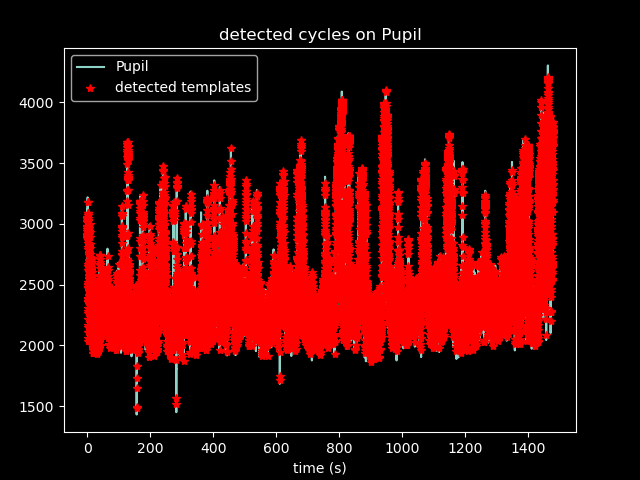

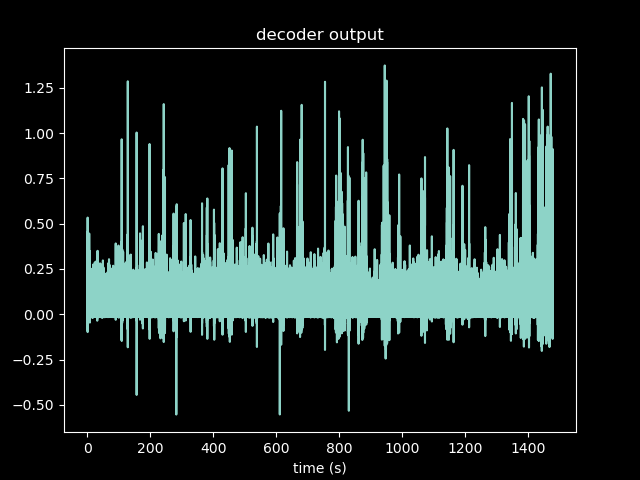

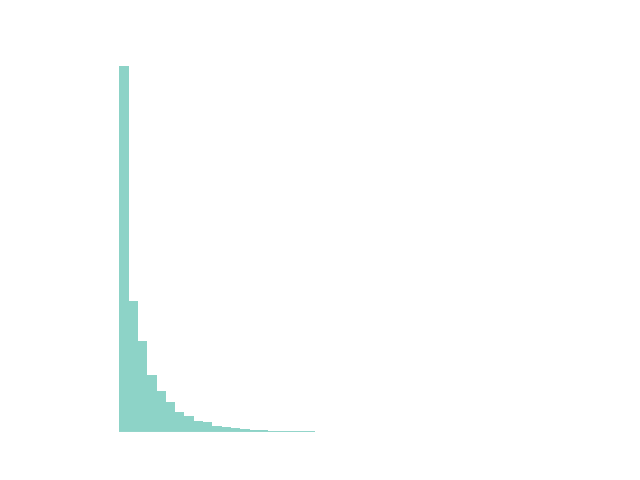

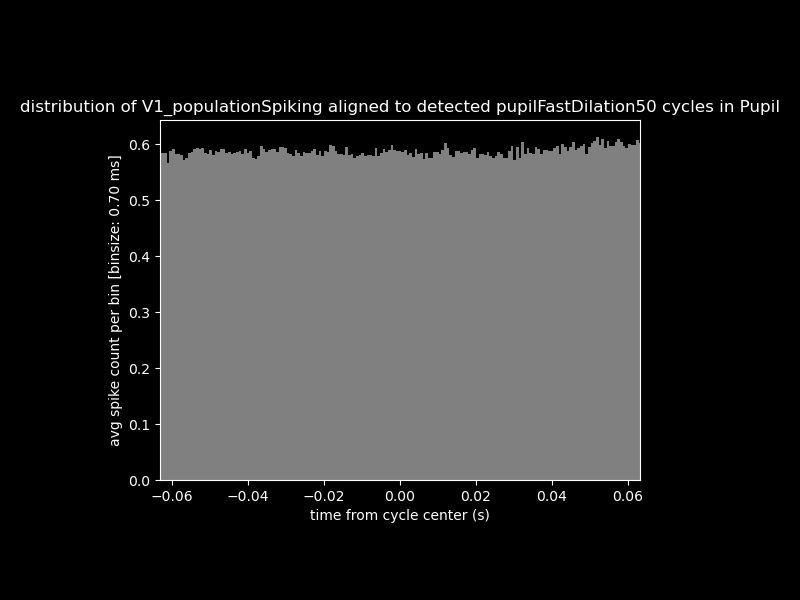

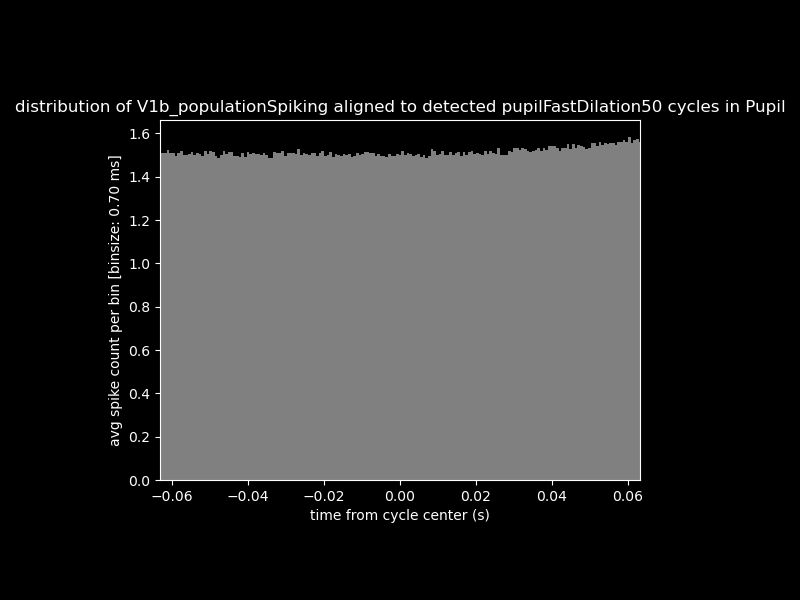

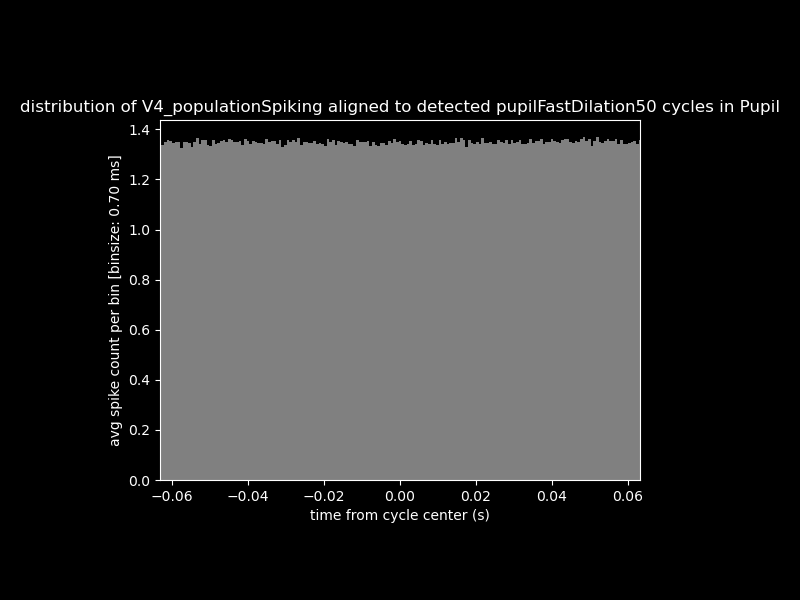

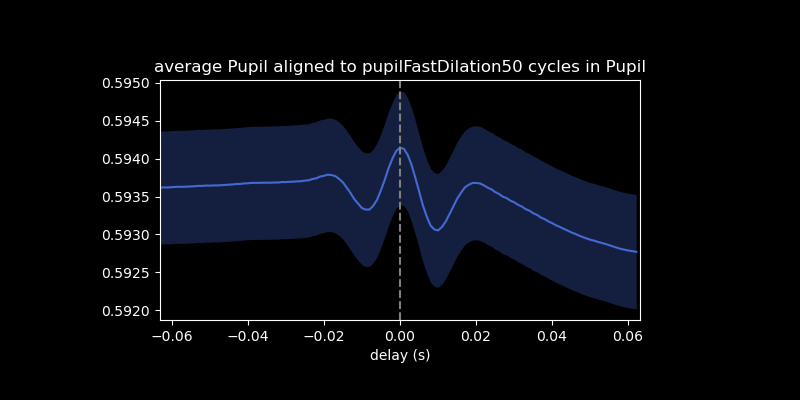

In [14]:
n = None
cycleName = 'pupilFastDilation50'
pupilFastDilationDur = 2/95
defaultHistBin=0

templateDetectedTimes_Pupil_fast50, triggeredActivityInAllregionsByDetectedCycles_Pupil_fast50, timePointsAllregions_fast50 =\
    populationDecoder.applyGeneralDecoder(inputAllRegions=allRegionsData, regionName='Pupil',\
        n=n, cycleName=cycleName, regionVec=regionsVec, regionsDataTypeVec=regionsDataTypeVec,\
            loadedModel_general_template=loadedModel_general_template,\
              dt_general_3s_template=dt_general_3s_template,\
                  binsAfter_general_template=binsAfter_general_template,\
                      binsBefore_general_template=binsBefore_general_template,\
                          detectionThreshold=chosenDetectionThreshold,\
                              showFigs=True, saveFigs=True, interCycleIntervalFig=True, targetedWidth=pupilFastDilationDur,\
                                  sessionName=sessionName, continuousInputSampingRate=cameraAvgFrameRate,\
                                     histBinWidth=defaultHistBin, highPassFilter=True, wholeSession=True, maxNumberForDeteced=2000)

### spike times relative to the pupil fast cycles - 100 hz

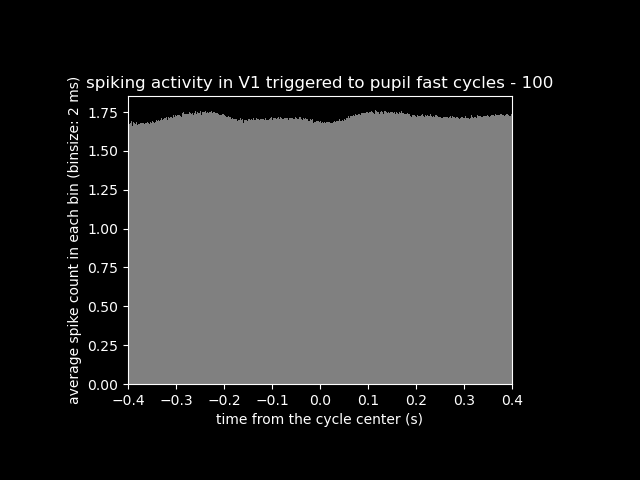

In [35]:
V1spikeTimes_Rel2_pupil_fast100 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=V1allSpikesTimes, eventsTime=templateDetectedTimes_Pupil_fast100,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(V1spikeTimes_Rel2_pupil_fast100)

V1spikeTimes_Rel2_pupil_fast100 = np.concatenate(V1spikeTimes_Rel2_pupil_fast100)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.002

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = V1spikeTimes_Rel2_pupil_fast100[(V1spikeTimes_Rel2_pupil_fast100>windowToZoomStart) & \
                                         (V1spikeTimes_Rel2_pupil_fast100<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the cycle center (s)')

ax.set_ylabel('average spike count in each bin (binsize: 2 ms)')

ax.set_title('spiking activity in V1 triggered to pupil fast cycles - 100')


ax.set_xbound(-0.4,0.4)

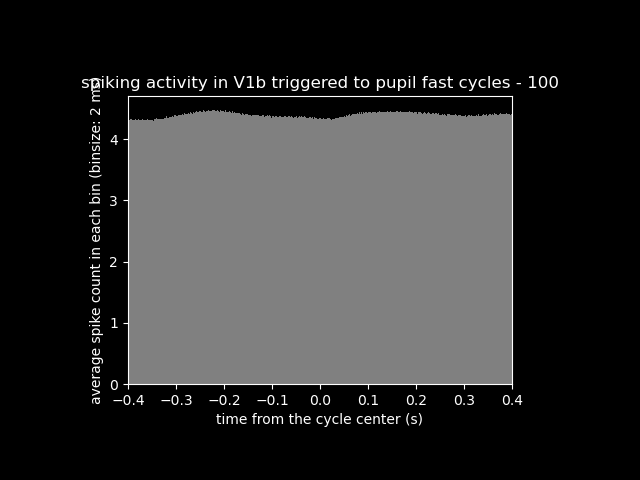

In [36]:
V1bspikeTimes_Rel2_pupil_fast100 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=V1bAllSpikesTimes, eventsTime=templateDetectedTimes_Pupil_fast100,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(V1bspikeTimes_Rel2_pupil_fast100)

V1bspikeTimes_Rel2_pupil_fast100 = np.concatenate(V1bspikeTimes_Rel2_pupil_fast100)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.002

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = V1bspikeTimes_Rel2_pupil_fast100[(V1bspikeTimes_Rel2_pupil_fast100>windowToZoomStart) & \
                                         (V1bspikeTimes_Rel2_pupil_fast100<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the cycle center (s)')

ax.set_ylabel('average spike count in each bin (binsize: 2 ms)')

ax.set_title('spiking activity in V1b triggered to pupil fast cycles - 100')


ax.set_xbound(-0.4,0.4)

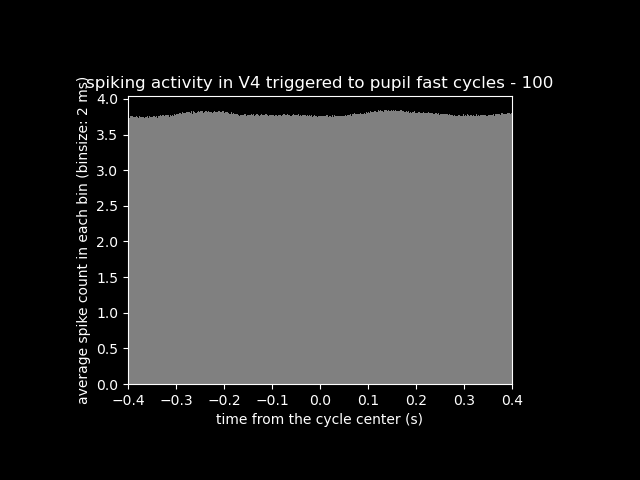

In [38]:
V4spikeTimes_Rel2_pupil_fast100 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=V4allSpikesTimes, eventsTime=templateDetectedTimes_Pupil_fast100,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(V4spikeTimes_Rel2_pupil_fast100)

V4spikeTimes_Rel2_pupil_fast100 = np.concatenate(V4spikeTimes_Rel2_pupil_fast100)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.002

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = V4spikeTimes_Rel2_pupil_fast100[(V4spikeTimes_Rel2_pupil_fast100>windowToZoomStart) & \
                                         (V4spikeTimes_Rel2_pupil_fast100<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the cycle center (s)')

ax.set_ylabel('average spike count in each bin (binsize: 2 ms)')

ax.set_title('spiking activity in V4 triggered to pupil fast cycles - 100')


ax.set_xbound(-0.4,0.4)

### spike times relative to the pupil fast cycles - 50 hz

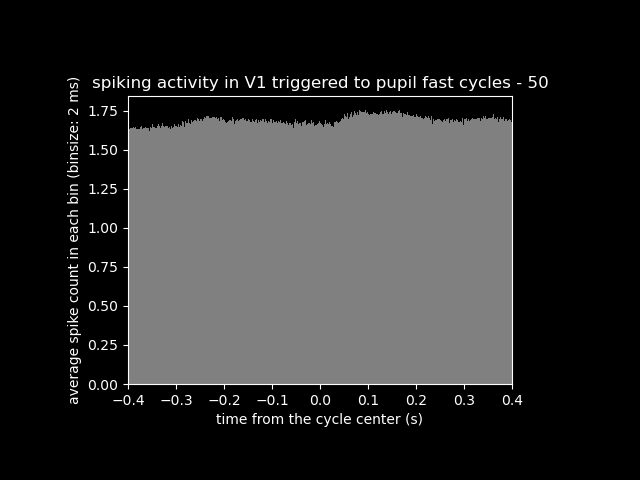

In [39]:
V1spikeTimes_Rel2_pupil_fast50 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=V1allSpikesTimes, eventsTime=templateDetectedTimes_Pupil_fast50,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(V1spikeTimes_Rel2_pupil_fast50)

V1spikeTimes_Rel2_pupil_fast50 = np.concatenate(V1spikeTimes_Rel2_pupil_fast50)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.002

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = V1spikeTimes_Rel2_pupil_fast50[(V1spikeTimes_Rel2_pupil_fast50>windowToZoomStart) & \
                                         (V1spikeTimes_Rel2_pupil_fast50<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the cycle center (s)')

ax.set_ylabel('average spike count in each bin (binsize: 2 ms)')

ax.set_title('spiking activity in V1 triggered to pupil fast cycles - 50')


ax.set_xbound(-0.4,0.4)

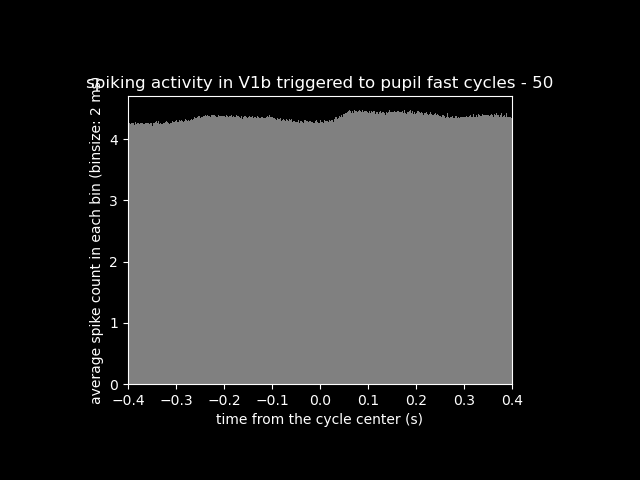

In [46]:
V1bspikeTimes_Rel2_pupil_fast50 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=V1bAllSpikesTimes, eventsTime=templateDetectedTimes_Pupil_fast50,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(V1bspikeTimes_Rel2_pupil_fast50)

V1bspikeTimes_Rel2_pupil_fast50 = np.concatenate(V1bspikeTimes_Rel2_pupil_fast50)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.002

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = V1bspikeTimes_Rel2_pupil_fast50[(V1bspikeTimes_Rel2_pupil_fast50>windowToZoomStart) & \
                                         (V1bspikeTimes_Rel2_pupil_fast50<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the cycle center (s)')

ax.set_ylabel('average spike count in each bin (binsize: 2 ms)')

ax.set_title('spiking activity in V1b triggered to pupil fast cycles - 50')


ax.set_xbound(-0.4,0.4)

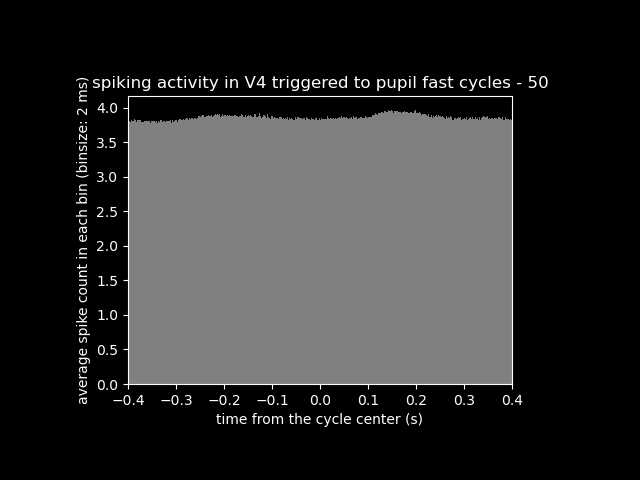

In [42]:
V4spikeTimes_Rel2_pupil_fast50 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=V4allSpikesTimes, eventsTime=templateDetectedTimes_Pupil_fast50,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(V4spikeTimes_Rel2_pupil_fast50)

V4spikeTimes_Rel2_pupil_fast50 = np.concatenate(V4spikeTimes_Rel2_pupil_fast50)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.002

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = V4spikeTimes_Rel2_pupil_fast50[(V4spikeTimes_Rel2_pupil_fast50>windowToZoomStart) & \
                                         (V4spikeTimes_Rel2_pupil_fast50<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the cycle center (s)')

ax.set_ylabel('average spike count in each bin (binsize: 2 ms)')

ax.set_title('spiking activity in V4 triggered to pupil fast cycles - 50')


ax.set_xbound(-0.4,0.4)

### pupil spectral analysis

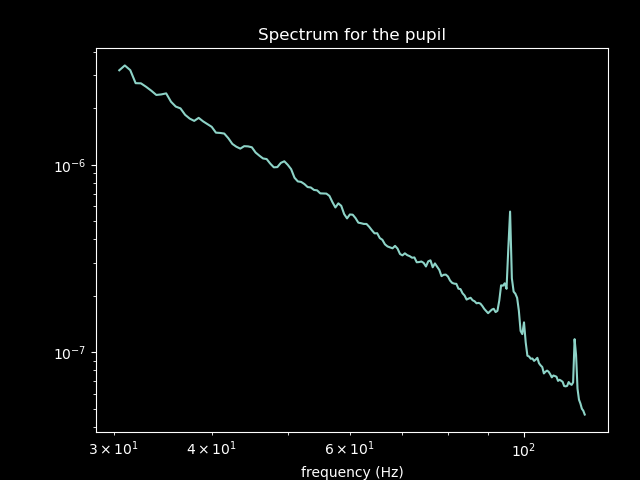

In [16]:
slow_clocks.spectrumFigure(pupilSize_corrected, dt=1/cameraAvgFrameRate,freqRes = 0.5,FR_highPassBand = 1, minFreq=30,\
                          maxFreq = 120, figTitle='Spectrum for the pupil', ylogscale=True, xlogscale=True,\
                          FR_highPass=False, xlogBase=10, alphaPatch=1);

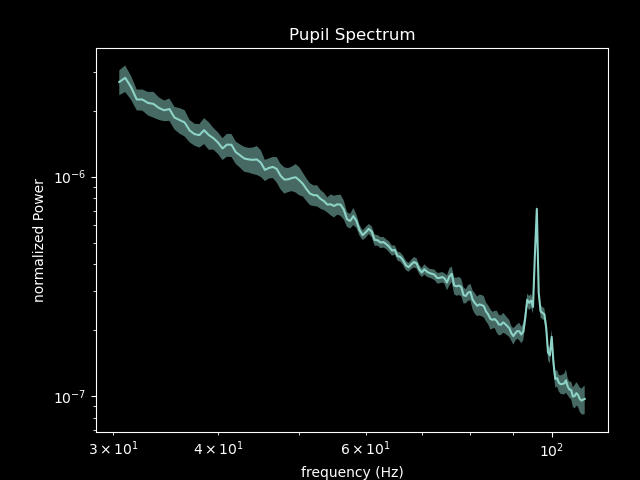

In [49]:
sessionDur = len(pupilSize_corrected)/cameraAvgFrameRate
epochLength = 0.3*60
epochNo = int(sessionDur/epochLength)

powerSpectrum_allEpochs = []
for epochCounter in range(epochNo):
    
    rawDataEpoch = pupilSize[int(epochCounter*epochLength*cameraAvgFrameRate):\
                                    int((epochCounter+1)*epochLength*cameraAvgFrameRate)]
    
    
    invalideRawDataRatio = len(np.where(rawDataEpoch==0)[0])/(epochLength*cameraAvgFrameRate)
    
#     print(invalideRawDataRatio)
    
    if invalideRawDataRatio<0.1:
    
        dataForFFT = pupilSize_corrected[int(epochCounter*epochLength*cameraAvgFrameRate):\
                                        int((epochCounter+1)*epochLength*cameraAvgFrameRate)]



        powerSpectrumL23, f = slow_clocks.spectrumFigure(dataForFFT, dt=1/cameraAvgFrameRate,freqRes = 0.5,FR_highPassBand = 1, minFreq=30,\
                                  maxFreq = 110, figTitle='Spectrum for the pupil', ylogscale=True, xlogscale=True,\
                                  FR_highPass=False, xlogBase=10, alphaPatch=1, showFig=False);

        powerSpectrum_allEpochs.append(powerSpectrumL23)
    
    
minFreq=30
maxFreq = 110
fig = plt.figure()
ax = fig.add_axes([0.15,0.1,0.8,0.8])
plt.semilogy(f[(f<maxFreq) & (f>minFreq)], np.mean(powerSpectrum_allEpochs,axis=0)[(f<maxFreq) & (f>minFreq)])
plt.fill_between(f[(f<maxFreq) & (f>minFreq)], np.mean(powerSpectrum_allEpochs,axis=0)[(f<maxFreq) & (f>minFreq)]-\
                                                    stats.sem(powerSpectrum_allEpochs,axis=0)[(f<maxFreq) & (f>minFreq)],\
                                                np.mean(powerSpectrum_allEpochs,axis=0)[(f<maxFreq) & (f>minFreq)]+\
                                                    stats.sem(powerSpectrum_allEpochs,axis=0)[(f<maxFreq) & (f>minFreq)],
                                                        alpha=0.5)
plt.xlabel('frequency (Hz)')
plt.ylabel('normalized Power')
plt.title('Pupil Spectrum')
ax.set_xscale('log', base=10)

### distribution of the gamma cycles in different areas relative to each other

In [52]:
gammaCycles_pupil_Rel2_V1 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=templateDetectedTimes_V1, eventsTime=templateDetectedTimes_Pupil,\
                                        responseWindowStart=1,responseWindowEnd=1)

gammaCycles_V1b_Rel2_V1 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=templateDetectedTimes_V1, eventsTime=templateDetectedTimes_V1b,\
                                        responseWindowStart=1,responseWindowEnd=1)

gammaCycles_V4_Rel2_V1 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=templateDetectedTimes_V1, eventsTime=templateDetectedTimes_V4,\
                                        responseWindowStart=1,responseWindowEnd=1)

gammaCycles_pupil_Rel2_V4 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=templateDetectedTimes_V1, eventsTime=templateDetectedTimes_Pupil,\
                                        responseWindowStart=1,responseWindowEnd=1)

### the relative timing of 50 and 100 Hz cycles

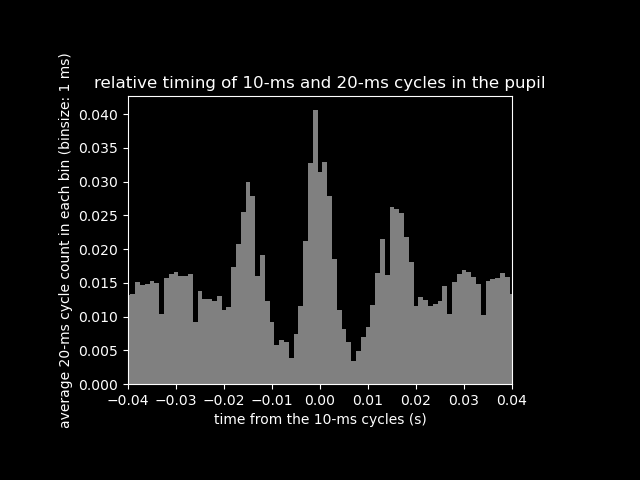

In [52]:
pupil_fast50_rel2_fast100 = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=templateDetectedTimes_Pupil_fast50, eventsTime=templateDetectedTimes_Pupil_fast100,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(pupil_fast50_rel2_fast100)

pupil_fast50_rel2_fast100 = np.concatenate(pupil_fast50_rel2_fast100)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.001

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = pupil_fast50_rel2_fast100[(pupil_fast50_rel2_fast100>windowToZoomStart) & \
                                         (pupil_fast50_rel2_fast100<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the 10-ms cycles (s)')

ax.set_ylabel('average 20-ms cycle count in each bin (binsize: 1 ms)')

ax.set_title('relative timing of 10-ms and 20-ms cycles in the pupil')


ax.set_xbound(-0.04,0.04)

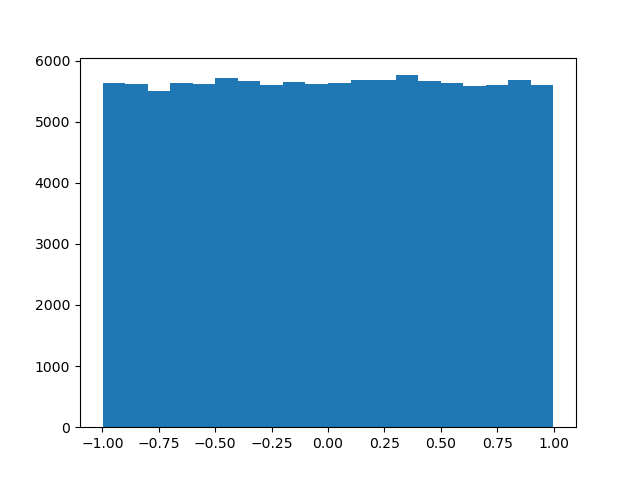

In [103]:
plt.figure()
plt.hist(np.concatenate(gammaCycles_pupil_Rel2_V1),bins=20);

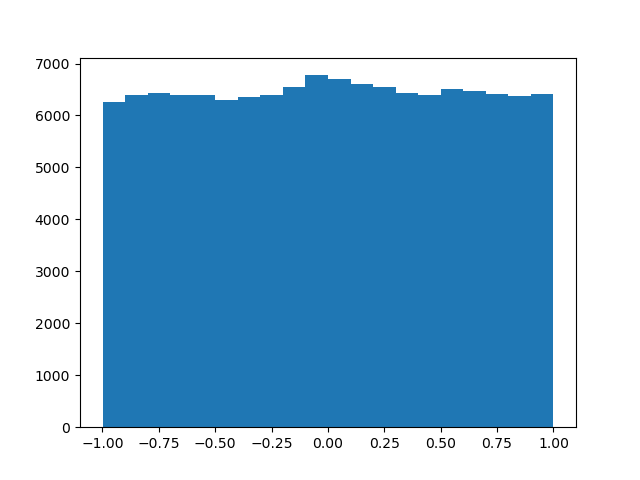

In [49]:
plt.figure()
plt.hist(np.concatenate(gammaCycles_V1b_Rel2_V1),bins=20);

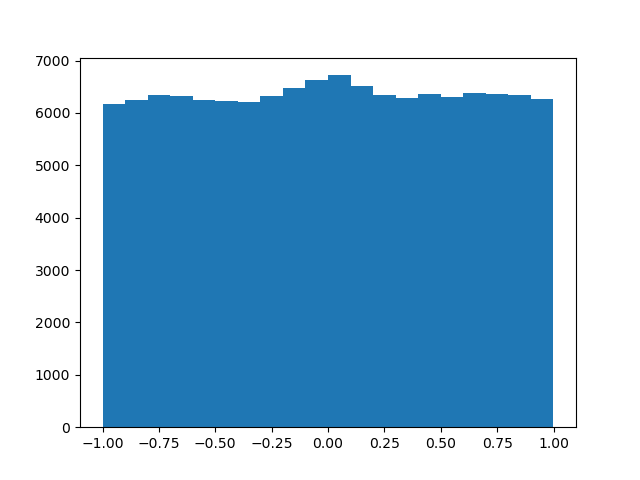

In [51]:
plt.figure()
plt.hist(np.concatenate(gammaCycles_V4_Rel2_V1),bins=20);

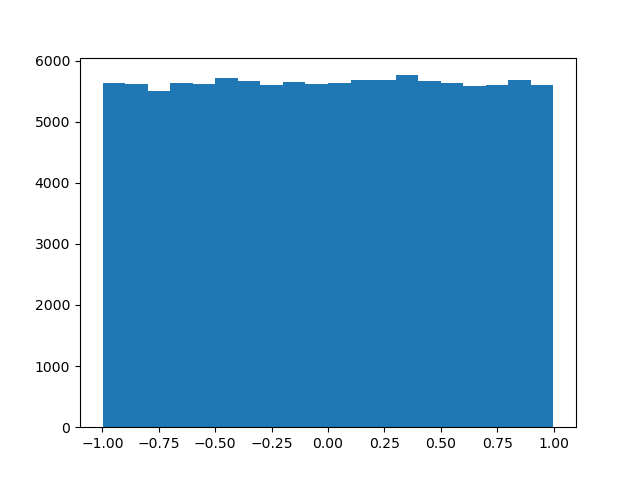

In [55]:
plt.figure()
plt.hist(np.concatenate(gammaCycles_pupil_Rel2_V4),bins=20);

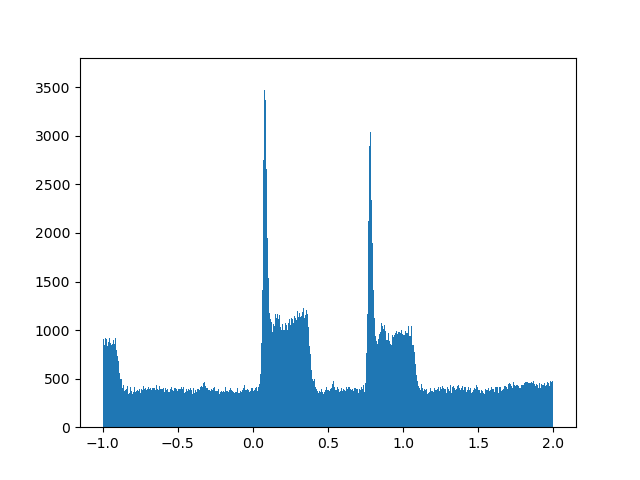

In [110]:
plt.figure()
plt.hist(np.concatenate(spike.eventTriggeredSpikingSingleCluster(spikesTime=V1allSpikesTimes,eventsTime=fristStimTimes,\
                            responseWindowEnd=2,responseWindowStart=1)),bins=2500);

## the relative timing of stimulus onset and gamma cycles

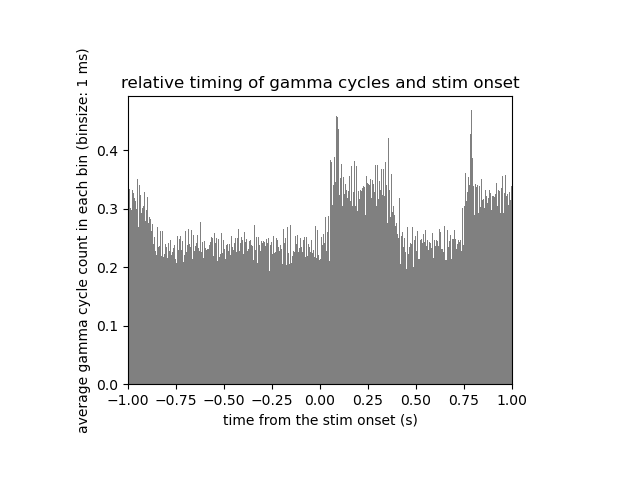

In [79]:
gamma_rel2_stim = spike.eventTriggeredSpikingSingleCluster(\
                             spikesTime=templateDetectedTimes_V1, eventsTime=fristStimTimes,\
                                        responseWindowStart=1,responseWindowEnd=1)

cyclesNo = len(gamma_rel2_stim)

gamma_rel2_stim = np.concatenate(gamma_rel2_stim)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.005

windowToZoomStart = -1
windowToZoomEnd = 1

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = gamma_rel2_stim[(gamma_rel2_stim>windowToZoomStart) & \
                                         (gamma_rel2_stim<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey')

ax.set_xlabel('time from the stim onset (s)')

ax.set_ylabel('average gamma cycle count in each bin (binsize: 1 ms)')

ax.set_title('relative timing of gamma cycles and stim onset')


ax.set_xbound(-1,1)

#### align the trials based on the first gamma cycle following the arrival of the info to V1

In [94]:
V1responseDelay = 0.05
delayToFirstCycle = []

for trialCounter in range(len(fristStimTimes)):
    
    stimOnsetTime = fristStimTimes[trialCounter]
    V1_stimInfoTime = stimOnsetTime + V1responseDelay
    
    stimGammaCycleTime = templateDetectedTimes_V1[np.where(templateDetectedTimes_V1>V1_stimInfoTime)[0][0]] - stimOnsetTime
    
    delayToFirstCycle.append(stimGammaCycleTime)

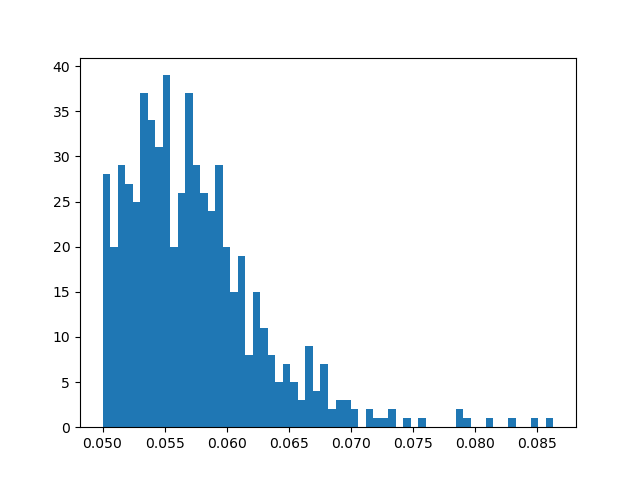

In [95]:
plt.figure()
plt.hist(delayToFirstCycle,bins=60);

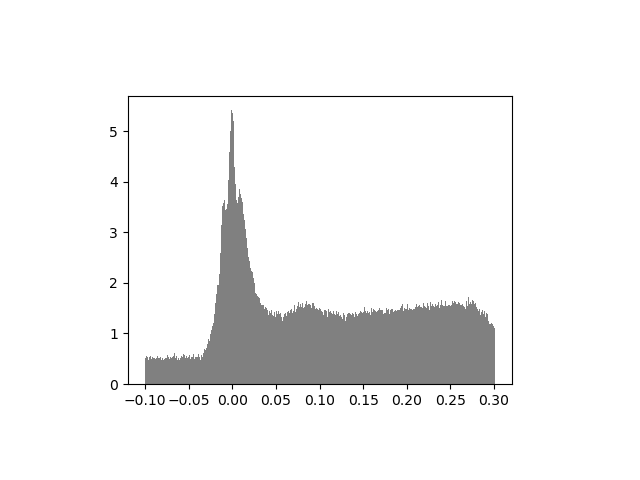

In [108]:
V1responseDelay = 0.08
delayToFirstCycle = []

for trialCounter in range(len(fristStimTimes)):
    
    stimOnsetTime = fristStimTimes[trialCounter]
    V1_stimInfoTime = stimOnsetTime + V1responseDelay
    
    # the first gamma cycle after the assumed delay
#     stimGammaCycleTime = templateDetectedTimes_V1[np.where(templateDetectedTimes_V1>V1_stimInfoTime)[0][0]] - stimOnsetTime
    
    # the closest gamma cycle to the assumed delay
    stimGammaCycleTime = templateDetectedTimes_V1[np.argmin(np.abs(templateDetectedTimes_V1 - V1_stimInfoTime))] - stimOnsetTime
    
    delayToFirstCycle.append(stimGammaCycleTime)


realignedStimOnset = fristStimTimes + delayToFirstCycle

realignedResponse = np.concatenate(spike.eventTriggeredSpikingSingleCluster(spikesTime=V1allSpikesTimes,eventsTime=realignedStimOnset,\
                            responseWindowEnd=0.3,responseWindowStart=0.1))

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.001

windowToZoomStart = -0.1
windowToZoomEnd = 0.3

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = realignedResponse[(realignedResponse>windowToZoomStart) & \
                                         (realignedResponse<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey');

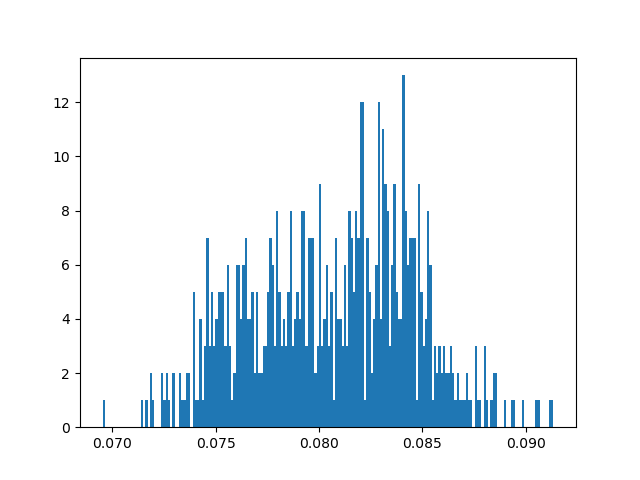

In [109]:
plt.figure()
plt.hist(delayToFirstCycle,bins=200);

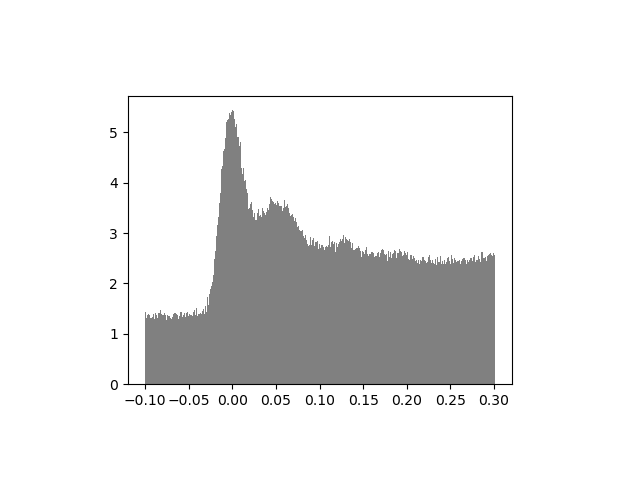

In [105]:
ealignedStimOnset = fristStimTimes + delayToFirstCycle

realignedResponse = np.concatenate(spike.eventTriggeredSpikingSingleCluster(spikesTime=V4allSpikesTimes,eventsTime=realignedStimOnset,\
                            responseWindowEnd=0.3,responseWindowStart=0.1))

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.001

windowToZoomStart = -0.1
windowToZoomEnd = 0.3

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = realignedResponse[(realignedResponse>windowToZoomStart) & \
                                         (realignedResponse<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey');

In [98]:
realignedResponse = np.concatenate(spike.eventTriggeredSpikingSingleCluster(spikesTime=V1allSpikesTimes,eventsTime=realignedStimOnset,\
                            responseWindowEnd=0.3,responseWindowStart=0.1))

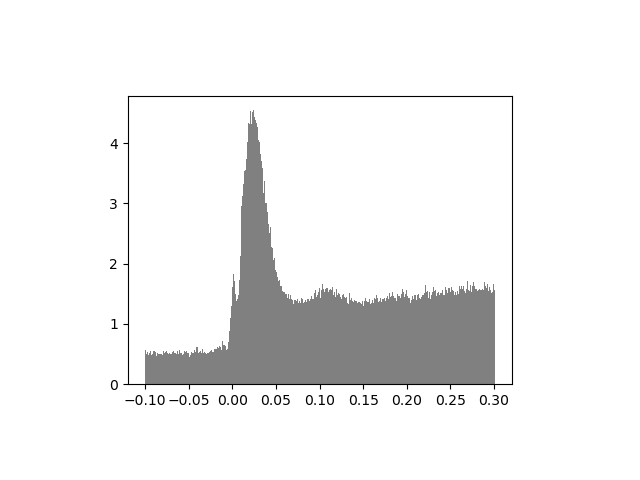

In [99]:
fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.6,0.6])
binsize = 0.001

windowToZoomStart = -0.1
windowToZoomEnd = 0.3

windowLen = windowToZoomEnd - windowToZoomStart

binsNo = int(windowLen/binsize)

dataToPlot = realignedResponse[(realignedResponse>windowToZoomStart) & \
                                         (realignedResponse<windowToZoomEnd)]

counts, bins = np.histogram(dataToPlot,bins=binsNo,\
                                normed=False)

plt.hist(bins[:-1], bins, weights=counts*np.ones(len(counts))/cyclesNo,\
            align='right',color='grey');

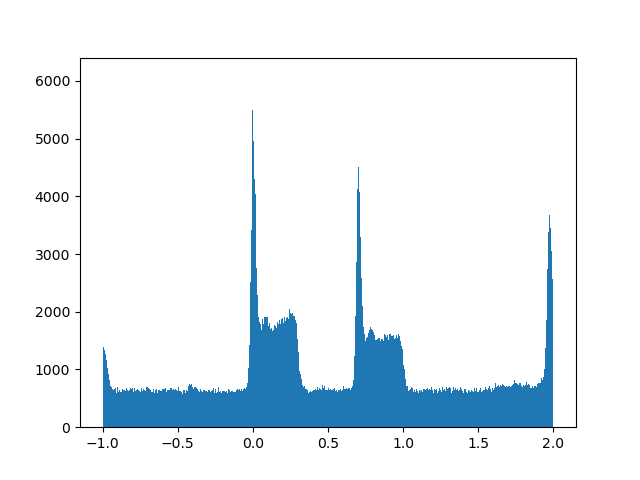

In [72]:
plt.figure()
plt.hist(realignedResponse,bins=1500);